In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
import keras_tuner as kt
from tqdm import tqdm
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from joblib import Parallel, delayed
import torch
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import array_to_img
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [2]:
# def read_image(image_path, mask=False):
#     image = tf.io.read_file(image_path)
#     if mask:
#         image = tf.image.decode_png(image, channels=1)
#         image.set_shape([None, None, 1])
#         image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
#     else:
#         image = tf.image.decode_png(image, channels=3)
#         image.set_shape([None, None, 3])
#         image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
#         image = image / 127.5 - 1
#     return image
#
# def read_mask(image_path):
#     image = tf.io.read_file(image_path)
#     image = tf.image.decode_png(image, channels=1)
#     image.set_shape([None, None, 1])
#     return image
# # def infer(model, image_tensor):
# #     predictions = model.predict(np.expand_dims(image_tensor, axis=0))
# #     predictions = np.squeeze(predictions)
# #     predictions = np.argmax(predictions, axis=2)
# #     return predictions
#
# def infer(model, image_tensor):
#     predictions = model.predict(np.expand_dims(image_tensor, axis=0))
#     predictions = np.squeeze(predictions)
#     predictions = np.argmax(predictions, axis=2)
#
#     predictions = tf.expand_dims(predictions,axis = 2)
#     predictions = tf.image.resize(predictions,size=(520,704))
#     nclass = np.amax(predictions)
#     predictions = predictions > .95 * nclass
#     predictions = tf.cast(predictions , dtype= tf.float32)
#
#     return predictions, nclass
#
#
# def decode_segmentation_masks(mask, colormap, n_classes):
#     r = np.zeros_like(mask).astype(np.uint8)
#     g = np.zeros_like(mask).astype(np.uint8)
#     b = np.zeros_like(mask).astype(np.uint8)
#     for l in range(0, n_classes):
#         idx = mask == l
#         r[idx] = colormap[l, 0]
#         g[idx] = colormap[l, 1]
#         b[idx] = colormap[l, 2]
#     rgb = np.stack([r, g, b], axis=2)
#     return rgb
#
#
# def get_overlay(image, colored_mask):
#     image = tf.keras.preprocessing.image.array_to_img(image)
#     image = np.array(image).astype(np.uint8)
#     overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
#     return overlay
#
#
# def plot_samples_matplotlib(display_list, figsize=(5, 3)):
#     _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
#     for i in range(len(display_list)):
#         if display_list[i].shape[-1] == 3:
#             axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
#         else:
#             axes[i].imshow(display_list[i])
#     plt.show()
# ## Based on: https://www.kaggle.com/eigrad/convert-rle-to-bounding-box-x0-y0-x1-y1
def rle2mask(rle, img_w, img_h):

    ## transforming the string into an array of shape (2, N)
    array = np.fromiter(rle.split(), dtype = np.uint)
    array = array.reshape((-1,2)).T
    array[0] = array[0] - 1

    ## decompressing the rle encoding (ie, turning [3, 1, 10, 2] into [3, 4, 10, 11, 12])
    # for faster mask construction
    starts, lenghts = array
    mask_decompressed = np.concatenate([np.arange(s, s + l, dtype = np.uint) for s, l in zip(starts, lenghts)])

    ## Building the binary mask
    msk_img = np.zeros(img_w * img_h, dtype = np.uint8)
    msk_img[mask_decompressed] = 1
    msk_img = msk_img.reshape((img_h, img_w))
    msk_img = np.asfortranarray(msk_img) ## This is important so pycocotools can handle this object

    return msk_img

In [3]:
# load models
# models = []
# path_models = "C:/kaggletemp/sartorius-cell-instance-segmentation/cv/run_fromkaggle_deepv3/"
# for i in range(4):
#     models.append( tf.keras.models.load_model( path_models + "model"+str(i) )  )



In [4]:
DATA_DIR = "C:/kaggletemp/sartorius-cell-instance-segmentation/"
DATA_MASK = "C:/kaggletemp/sartorius-cell-instance-segmentation/mask_one_channel_cleaned"
IMAGE_SIZE = 512
df = pd.read_csv( os.path.join(DATA_DIR, 'train.csv') )
df['img'] = [os.path.join(DATA_DIR,'train/' + x + '.png') for x in df.id]
ann = df[ df.id == '0030fd0e6378'].annotation
mask = sum ([ rle2mask( x, 704,520 ) for x in ann])
mask = mask.clip(0,1)
# test = glob.glob(DATA_DIR + "/test/*")
# im =  ( glob.glob(DATA_DIR + '/train/*.png') )#
#ms = (  glob.glob(DATA_MASK + "/*") )
#plt.imshow(mask)

# df_type = df[df[ 'cell_type'] == 'astro']
# total = dfx.groupby('id').first()
# df_unique = df.groupby('id').first()

In [5]:
from pycocotools import mask as maskUtils

In [6]:
# train_data = pd.read_csv(os.path.join(DATA_DIR,'train.csv') )
# aux_train = pd.read_csv(os.path.join(DATA_DIR,'train.csv') )
#
# #train_data[['id', 'cell_type']].drop_duplicates(subset=  ['id'])
# aux_train = aux_train.groupby('id').first().reset_index()
# data = { 'img' : im, 'mask' : ms}
# df= pd.DataFrame(data= data)
# df.head()
#
# # merge types:
#
# df['id']  = df.img.map(lambda a:  os.path.split(a)[1].split(".png")[0])
# df['type'] = df.id.map(aux_train.set_index('id').cell_type )
# df.groupby([ 'type']).count()

In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml" ))
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
cfg.MODEL.WEIGHTS = os.path.join(  'output', "model_final.pth")  #


In [8]:
# def post_process(mask, min_size=30, shape=(520, 704,)):
#     num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
#     predictions = []
#     for c in range(1, num_component):
#         p = (component == c)
#         if p.sum() > min_size:
#             a_prediction = np.zeros(shape, np.float32)
#             a_prediction[p] = 1
#             predictions.append(a_prediction)
#     return predictions
#
# def rles_to_mask(encs, shape):
#     """
#     Decodes a rle.
#
#     Args:
#         encs (list of str): Rles for each class.
#         shape (tuple [2]): Mask size.
#
#     Returns:
#         np array [shape]: Mask.
#     """
#     img = np.zeros(shape[0] * shape[1], dtype=np.uint)
#     if type(encs)==float:
#         return img
#     for m, enc in enumerate(encs):
#         if isinstance(enc, np.float) and np.isnan(enc):
#             continue
#         enc_split = enc.split()
#         for i in range(len(enc_split) // 2):
#             start = int(enc_split[2 * i]) - 1
#             length = int(enc_split[2 * i + 1])
#             img[start: start + length] = 1 + m
#     return img.reshape(shape)

# def compute_iou(labels, y_pred):
#     """
#     Computes the IoU for instance labels and predictions.
#
#     Args:
#         labels (np array): Labels.
#         y_pred (np array): predictions
#
#     Returns:
#         np array: IoU matrix, of size true_objects x pred_objects.
#     """
#
#     true_objects = len(np.unique(labels))
#     pred_objects = len(np.unique(y_pred))
#
#     # Compute intersection between all objects
#     intersection = np.histogram2d(
#         labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
#     )[0]
#
#     # Compute areas (needed for finding the union between all objects)
#     area_true = np.histogram(labels, bins=true_objects)[0]
#     area_pred = np.histogram(y_pred, bins=pred_objects)[0]
#     area_true = np.expand_dims(area_true, -1)
#     area_pred = np.expand_dims(area_pred, 0)
#
#     # Compute union
#     union = area_true + area_pred - intersection
#     iou = intersection / union
#
#     return iou[1:, 1:]  # exclude background
#
# def precision_at(threshold, iou):
#     """
#     Computes the precision at a given threshold.
#
#     Args:
#         threshold (float): Threshold.
#         iou (np array [n_truths x n_preds]): IoU matrix.
#
#     Returns:
#         int: Number of true positives,
#         int: Number of false positives,
#         int: Number of false negatives.
#     """
#     matches = iou > threshold
#     true_positives = np.sum(matches, axis=1) >= 1  # Correct objects
#     false_negatives = np.sum(matches, axis=1) == 0  # Missed objects
#     false_positives = np.sum(matches, axis=0) == 0  # Extra objects
#     tp, fp, fn = (
#         np.sum(true_positives),
#         np.sum(false_positives),
#         np.sum(false_negatives),
#     )
#     return tp, fp, fn
#
# from tqdm.auto import tqdm
# def iou_map(truths, preds, verbose=0):
#     """
#     Computes the metric for the competition.
#     Masks contain the segmented pixels where each object has one value associated,
#     and 0 is the background.
#
#     Args:
#         truths (list of masks): Ground truths.
#         preds (list of masks): Predictions.
#         verbose (int, optional): Whether to print infos. Defaults to 0.
#
#     Returns:
#         float: mAP.
#     """
#     # ious = [
#     #     compute_iou(rles_to_mask(truth,shape), rles_to_mask(pred,shape))
#     #         for truth, pred in tqdm(zip(truths, preds))
#     # ]
#     ious = compute_iou(truths,preds)
#     if verbose:
#         print(ious[0].shape)
#         print("Thresh\tTP\tFP\tFN\tPrec.")
#
#     prec = []
#     for t in np.arange(0.5, 1.0, 0.05):
#         tps, fps, fns = 0, 0, 0
#         for iou in ious:
#             tp, fp, fn = precision_at(t, iou)
#             tps += tp
#             fps += fp
#             fns += fn
#
#         p = tps / (tps + fps + fns)
#         prec.append(p)
#
#         if verbose:
#             print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tps, fps, fns, p))
#
#     if verbose:
#         print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
#
#     return np.mean(prec)

In [9]:
def compute_iou(labels, y_pred):
    """
    Computes the IoU for instance labels and predictions.

    Args:
        labels (np array): Labels.
        y_pred (np array): predictions

    Returns:
        np array: IoU matrix, of size true_objects x pred_objects.
    """

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
    iou = intersection / union

    return iou[1:, 1:]  # exclude background

def precision_at(threshold, iou):
    """
    Computes the precision at a given threshold.

    Args:
        threshold (float): Threshold.
        iou (np array [n_truths x n_preds]): IoU matrix.

    Returns:
        int: Number of true positives,
        int: Number of false positives,
        int: Number of false negatives.
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) >= 1  # Correct objects
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects
    false_positives = np.sum(matches, axis=0) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn

def iou_map(truths, preds, verbose=0):
    """
    Computes the metric for the competition.
    Masks contain the segmented pixels where each object has one value associated,
    and 0 is the background.

    Args:
        truths (list of masks): Ground truths.
        preds (list of masks): Predictions.
        verbose (int, optional): Whether to print infos. Defaults to 0.

    Returns:
        float: mAP.
    """
    ious = [compute_iou(truth, pred) for truth, pred in zip(truths, preds)]

    #print(ious[0].shape)

    if verbose:
        print("Thresh\tTP\tFP\tFN\tPrec.")

    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tps, fps, fns = 0, 0, 0
        for iou in ious:
            tp, fp, fn = precision_at(t, iou)
            tps += tp
            fps += fp
            fns += fn

        p = tps / (tps + fps + fns)
        prec.append(p)

        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tps, fps, fns, p))

    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)



In [10]:
# x = infer(models[0],read_image( df['img'][0] , mask = False) )[0]
# plt.imshow(x)

In [11]:
df[df[ 'cell_type'] == 'astro'] .groupby('id').first()

,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta,img
id,,,,,,,,,
0140b3c8f445,32499 3 33201 7 33902 9 34604 10 35306 11 3600...,704,520,astro,09h00m00s,2020-09-13,astros[cereb]_F8-3_Vessel-361_Ph_4,0 days 09:00:00,C:/kaggletemp/sartorius-cell-instance-segmenta...
085eb8fec206,15779 2 16481 5 17185 5 17889 6 18593 7 19297 ...,704,520,astro,13h00m00s,2020-09-15,astro[hippo]_G1-3_Vessel-361_Ph_3,0 days 13:00:00,C:/kaggletemp/sartorius-cell-instance-segmenta...
08f52aa2add3,181021 1 181723 4 182426 5 183130 6 183833 7 1...,704,520,astro,13h00m00s,2020-09-16,astro[hippo]_F5-3_Vessel-361_Ph_1,0 days 13:00:00,C:/kaggletemp/sartorius-cell-instance-segmenta...
0a6ecc5fe78a,329777 8 330480 9 331184 9 331887 11 332591 11...,704,520,astro,09h00m00s,2020-09-13,astros[cereb]_G11-4_Vessel-361_Ph_4,0 days 09:00:00,C:/kaggletemp/sartorius-cell-instance-segmenta...
0c90b86742b2,388 12 1091 13 1795 13 2498 13 3202 13 3905 14...,704,520,astro,09h00m00s,2020-09-14,astros[cereb]_G10-4_Vessel-361_Ph_1,0 days 09:00:00,C:/kaggletemp/sartorius-cell-instance-segmenta...
...,...,...,...,...,...,...,...,...,...
faa16dd8abd3,249245 7 249942 14 250645 15 251349 15 252052 ...,704,520,astro,09h00m00s,2020-09-13,astros[cereb]_G12-4_Vessel-361_Ph_4,0 days 09:00:00,C:/kaggletemp/sartorius-cell-instance-segmenta...
fac5fa0dd448,229217 1 229920 3 230623 4 231316 5 231327 5 2...,704,520,astro,09h00m00s,2020-09-13,astros[cereb]_D7-2_Vessel-361_Ph_4,0 days 09:00:00,C:/kaggletemp/sartorius-cell-instance-segmenta...
fd98d82784a1,335979 1 336681 3 337385 3 338088 3 338792 3 3...,704,520,astro,13h00m00s,2020-09-14,astro[hippo]_G1-4_Vessel-361_Ph_3,0 days 13:00:00,C:/kaggletemp/sartorius-cell-instance-segmenta...


In [12]:
thr = .5
class_id = { 'shsy5y' : 1, 'astro':2, 'cort' : 3 }
width = 704
height = 520
shape = [height,width]

from pycocotools import mask as maskUtils

def get_iou_trh(thr,ctype):
    masks = []
    preds = []
    df_unique = df[df[ 'cell_type'] == ctype].groupby('id', as_index = False).first()
    total  = df_unique.shape[0]
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = thr # torch.FloatTensor(thr ) #.astype(np.float32)
    predictor = DefaultPredictor(cfg)
    for index, row in  tqdm(df_unique.iterrows(), total = total) :   #df[df['type']==ctype].iterrows():

        masks = preds =[]
        img = cv2.imread( idxp )
        #print(img.shape)
        pred = predictor ( img )
        res = pred['instances'].pred_masks.cpu().numpy()
        predx = np.sum(res, axis = 0).clip(0,1).astype(np.uint8)

        ann = df[ df.id == idx].annotation
        mask = sum ([ rle2mask( x, 704,520 ) for x in ann])
        mask = mask.clip(0,1)

        masks.append(mask)
        preds.append(predx)
    return  iou_map(masks,preds)

def plot_thr(ones,thrs):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x = thrs
    y = ones
    line, = ax.plot(x, y)

    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]

    def annot_max(x,y, ax=None):
        xmax = x[np.argmax(y)]
        ymax = max(y)
        text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
        if not ax:
            ax=plt.gca()
        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
        kw = dict(xycoords='data',textcoords="axes fraction",
                  arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
        ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

    annot_max(x,y)

    ax.set_ylim(0,1.5 * max(y))
    plt.show()


def get_best_tr(ctype):
    thrs = (.2,.4,.6,.8)
    #ones = []

    res = Parallel(n_jobs= 6 )(delayed(get_iou_trh)(thr,ctype = ctype) for thr in (.2,.4,.6,.8) )

    # for i in np.arange(0,1,.1):
    #    ones.append( get_iou_trh(i,ctype))
    #ones.append(  res)
    ones = res.tolist()[0]
    plot_thr(ones, thrs)





In [13]:
def plot_thr(ones,thrs):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x = thrs
    y = ones
    line, = ax.plot(x, y)

    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]

    def annot_max(x,y, ax=None):
        xmax = x[np.argmax(y)]
        ymax = max(y)
        text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
        if not ax:
            ax=plt.gca()
        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
        kw = dict(xycoords='data',textcoords="axes fraction",
                  arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
        ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

    annot_max(x,y)

    ax.set_ylim(0,1.5 * max(y))
    plt.show()


In [14]:
#x = get_iou_trh(.5,"astro")
# thr = .5
# ctype = 'astro'
#
#
#
# masks = []
# preds = []
# df_unique = df[df[ 'cell_type'] == ctype].groupby('id', as_index = False).first()
# total  = df_unique.shape[0]
# for index, row in  tqdm(df_unique.iterrows(), total = total) :   #df[df['type']==ctype].iterrows():
#
#     masks = preds =[]
#     cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = thr
#     predictor = DefaultPredictor(cfg)
#     pathx= (row[ 'img'])
#     print(pathx)
#     img = cv2.imread( row['img'] )
#     x = predictor ( img )
#     res = x['instances'].pred_masks.cpu().numpy()
#     predx = np.sum(res, axis = 0).clip(0,1).astype(np.uint8)
#
#     ann = df[ df.id == row['id']].annotation
#     mask = sum ([ rle2mask( x, 704,520 ) for x in ann])
#
#
#     masks.append(mask)
#     preds.append(predx)
#return  iou_map(masks,preds)

In [ ]:
get_iou_trh(thr = .4, ctype = 'astro')
#cv2.imread('C:/kaggletemp/sartorius-cell-instance-segmentation/train/0140b3c8f445.png')

In [27]:
get_best_tr('astro')

AttributeError: 'list' object has no attribute 'tolist'

100%|██████████| 155/155 [00:37<00:00,  4.17it/s]


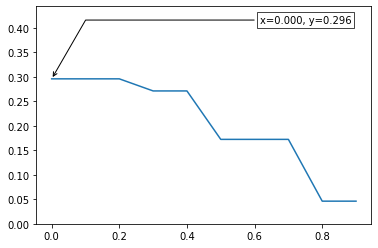

100%|██████████| 320/320 [01:16<00:00,  4.19it/s]


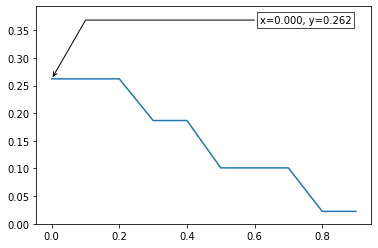

In [108]:
get_best_tr('shsy5y')
get_best_tr('cort')

In [43]:
x = np.arange(0,1,.1)
x

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

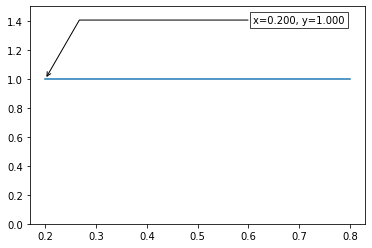

In [31]:
ctype = 'astro'
thrs = (.2,.4,.6,.8)
#ones = []

res = Parallel(n_jobs= 6 )(delayed(get_iou_trh)(thr,ctype = ctype) for thr in (.2,.4,.6,.8) )

# for i in np.arange(0,1,.1):
#    ones.append( get_iou_trh(i,ctype))
#ones.append(  res)
ones = res
plot_thr(ones, thrs)

In [29]:
( thrs, res)

((0.2, 0.4, 0.6, 0.8), [1.0, 1.0, 1.0, 1.0])

In [30]:
res.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
def get_iou_trh(thr,ctype):
    masks = []
    preds = []
    df_unique = df[df[ 'cell_type'] == ctype].groupby('id', as_index = False).first()
    total  = df_unique.shape[0]
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = thr # torch.FloatTensor(thr ) #.astype(np.float32)
    predictor = DefaultPredictor(cfg)
    for index, row in  tqdm(df_unique.iterrows(), total = total) :   #df[df['type']==ctype].iterrows():

        masks = preds =[]
        img = cv2.imread( row['img'] )
        #print(img.shape)
        x = predictor ( img )
        res = x['instances'].pred_masks.cpu().numpy()
        predx = np.sum(res, axis = 0)#.clip(0,1).astype(np.uint8)

        ann = df[ df.id == row['id']].annotation
        mask = sum ([ rle2mask( x, 704,520 ) for x in ann])


        masks.append(mask)
        preds.append(predx)
    return  iou_map(masks,preds)

63560 46575
64010 41205
18716 19995
71676 52779
Thresh	TP	FP	FN	Prec.
0.500	3	1	1	0.600
0.550	0	4	4	0.000
0.600	0	4	4	0.000
0.650	0	4	4	0.000
0.700	0	4	4	0.000
0.750	0	4	4	0.000
0.800	0	4	4	0.000
0.850	0	4	4	0.000
0.900	0	4	4	0.000
0.950	0	4	4	0.000
AP	-	-	-	0.060


0.06

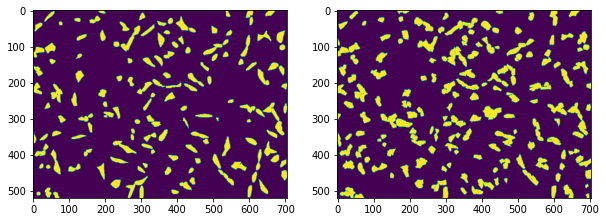

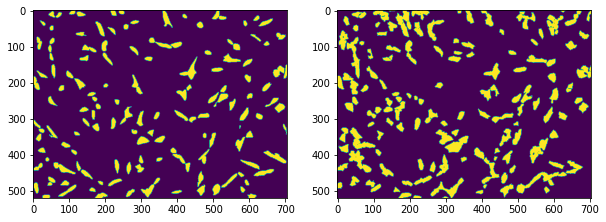

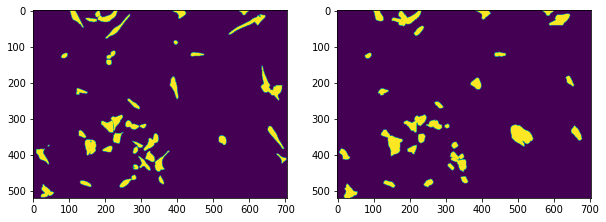

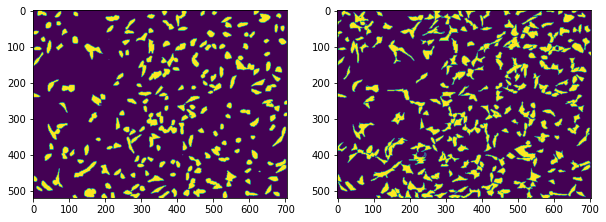

In [68]:
#idx = '0030fd0e6378'
idxp = 'C:/kaggletemp/sartorius-cell-instance-segmentation/train/0030fd0e6378.png'
ctype = 'shsy5y'
thr = .2
masks = []
preds = []
df_unique = df[df[ 'cell_type'] == ctype].groupby('id', as_index = False).first()
total  = df_unique.shape[0]
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = thr # torch.FloatTensor(thr ) #.astype(np.float32)
predictor = DefaultPredictor(cfg)



for idx in df_unique[-4:].id :
    img = cv2.imread(DATA_DIR + 'train/'+ idx + '.png' )
    #print(img.shape)
    pred = predictor ( img )
    res = pred['instances'].pred_masks.cpu().numpy()
    predx = np.sum(res, axis = 0).clip(0,1).astype(np.uint16)

    ann = df[ df.id == idx].annotation
    mask = sum ([ rle2mask( x, 704,520 ) for x in ann])
    mask = (mask.clip(0,1.1) ).astype(np.uint16)

    print (np.sum(mask), np.sum(predx))
    plot2(predx,mask)


    masks.append(mask)
    preds.append(predx)
iou_map(  masks,preds , verbose=True)


In [66]:
def plot2(a,b):
    f, axarr = plt.subplots(1,2,figsize=(10, 10))
    axarr[0].imshow(a)#cmap="Wistia")
    axarr[1].imshow(b)


#plot2(predx,mask)

In [59]:
def compute_iou(labels, y_pred):
    """
    Computes the IoU for instance labels and predictions.

    Args:
        labels (np array): Labels.
        y_pred (np array): predictions

    Returns:
        np array: IoU matrix, of size true_objects x pred_objects.
    """

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
    iou = intersection / union

    return iou[1:, 1:]  # exclude background

def precision_at(threshold, iou):
    """
    Computes the precision at a given threshold.

    Args:
        threshold (float): Threshold.
        iou (np array [n_truths x n_preds]): IoU matrix.

    Returns:
        int: Number of true positives,
        int: Number of false positives,
        int: Number of false negatives.
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) >= 1  # Correct objects
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects
    false_positives = np.sum(matches, axis=0) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn

def iou_map(truths, preds, verbose=0):
    """
    Computes the metric for the competition.
    Masks contain the segmented pixels where each object has one value associated,
    and 0 is the background.

    Args:
        truths (list of masks): Ground truths.
        preds (list of masks): Predictions.
        verbose (int, optional): Whether to print infos. Defaults to 0.

    Returns:
        float: mAP.
    """
    ious = [compute_iou(truth, pred) for truth, pred in zip(truths, preds)]

    #print(ious[0].shape)

    if verbose:
        print("Thresh\tTP\tFP\tFN\tPrec.")

    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tps, fps, fns = 0, 0, 0
        for iou in ious:
            tp, fp, fn = precision_at(t, iou)
            tps += tp
            fps += fp
            fns += fn

        p = tps / (tps + fps + fns)
        prec.append(p)

        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tps, fps, fns, p))

    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)

In [50]:
df_unique[-4:].id

151    f6abc09eb12f
152    f717a5f6d473
153    f8902ee8890c
154    fe3e30f849f4
Name: id, dtype: object

In [53]:
DATA_DIR + 'train/'+ idxp + '.png'

'C:/kaggletemp/sartorius-cell-instance-segmentation/train/C:/kaggletemp/sartorius-cell-instance-segmentation/train/0030fd0e6378.png.png'